Лабораторная работа 3. Классификация изображений

# Импорты

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
%matplotlib inline
from torchsummary import summary
import torchvision.models as models
from torchvision import transforms, datasets

# Задание 1

Для [набора данных](https://drive.google.com/drive/folders/1sPwKGt_BX0fwGFTwVcoC7opwLT41b9Ug?usp=sharing) взять два класса и построить модель бинарной классификации, постараться улучшить точность модели. Построить графики кривых обучения.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
!unzip /content/drive/MyDrive/ОМЗ/datasets-2-20241021T172557Z-001.zip -d /content

Archive:  /content/drive/MyDrive/ОМЗ/datasets-2-20241021T172557Z-001.zip
  inflating: /content/datasets-2/Apple___healthy/image (556).JPG  
  inflating: /content/datasets-2/Apple___healthy/image (183).JPG  
  inflating: /content/datasets-2/Apple___healthy/image (223).JPG  
  inflating: /content/datasets-2/Apple___healthy/image (436).JPG  
  inflating: /content/datasets-2/Apple___healthy/image (587).JPG  
  inflating: /content/datasets-2/Apple___healthy/image (506).JPG  
  inflating: /content/datasets-2/Apple___healthy/image (310).JPG  
  inflating: /content/datasets-2/Apple___healthy/image (100).JPG  
  inflating: /content/datasets-2/Apple___Cedar_apple_rust/image (27).JPG  
  inflating: /content/datasets-2/Apple___healthy/image (68).JPG  
  inflating: /content/datasets-2/Apple___healthy/image (17).JPG  
  inflating: /content/datasets-2/Apple___healthy/image (224).JPG  
  inflating: /content/datasets-2/Apple___healthy/image (338).JPG  
  inflating: /content/datasets-2/Apple___healthy/i

In [6]:
# Класс данных
class Apples(Dataset):
    def __init__(self, folder):
        healthy = glob(folder + '/Apple___healthy/*.JPG')
        sick = glob(folder + '/Apple___*/*.JPG')
        self.fpaths = healthy + sick
        from random import shuffle, seed; seed(10); shuffle(self.fpaths)
        self.targets = [not fpath.split('/')[-2].endswith('healthy') for fpath in self.fpaths]

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])  # Преобразование BGR в RGB
        im = cv2.resize(im, (224, 224))
        return torch.tensor(im / 255).permute(2, 0, 1).float(), torch.tensor([target]).float()

In [7]:
# Пример загрузки данных
folder = '/content/datasets-2'
data = Apples(folder)
im, label = data[200]

In [8]:
im.shape

torch.Size([3, 224, 224])

In [9]:
len(data)

2926

tensor([1.])


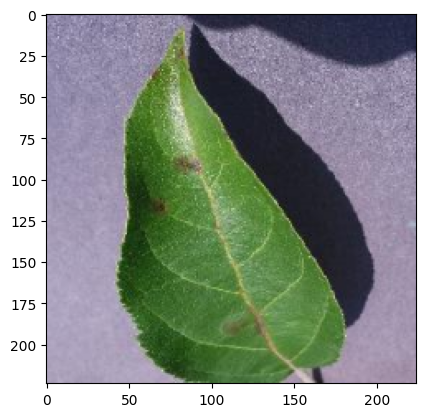

In [10]:
plt.imshow(im.permute(1,2,0).cpu()) # канал переставляем в конец, т.к. matplotlib ожидает, что изображение будет иметь каналы, указанные после того, как высота и ширина изображения были предоставлены
print(label)

### Создание и обучение однослойной CNN

In [11]:
# Модель, функция потерь и оптимизатор
def conv_layer(ni, no, kernel_size, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, no, kernel_size, stride),  # ni - количество каналов на входе, no - количество каналов на выходе, далее ядро и шаг (=1 по умолч)
        nn.ReLU(),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2)
    )

def get_model():
    model = nn.Sequential(
        conv_layer(3, 64, 3),  # Один свёрточный слой
        nn.Flatten(),
        nn.Linear(64 * 111 * 111, 1),  # Размер после свёрточного слоя и максимального пулинга
        nn.Sigmoid(),
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [12]:
# Функция для получения данных
def get_data():
    train_size = int(0.8 * len(data))
    val_size = len(data) - train_size
    train, val = random_split(data, [train_size, val_size])

    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
    val_dl = DataLoader(val, batch_size=32, shuffle=False, drop_last=True)

    return trn_dl, val_dl

In [13]:
# Определим функцию, обучающую на пакете данных
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    x, y = x.to(device), y.to(device)
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()  # обнуляет градиенты
    return batch_loss.item()

In [14]:
# Определим функцию точности
@torch.no_grad()
def accuracy(x, y, model):
    x, y = x.to(device), y.to(device)
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [15]:
# Определим функцию расчета потерь при проверке:
@torch.no_grad()
def val_loss(x, y, model):
    x, y = x.to(device), y.to(device)
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [18]:
# Функция для обучения модели
def train_model(get_data, get_model, train_batch, accuracy, num_epochs=5):
    # Определяем модель и получаем загрузчики данных
    trn_dl, val_dl = get_data()
    model, loss_fn, optimizer = get_model()
    print(model)

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        train_epoch_losses, train_epoch_accuracies = [], []
        val_epoch_accuracies = []

        for ix, batch in enumerate(iter(trn_dl)):
            x, y = batch
            batch_loss = train_batch(x, y, model, optimizer, loss_fn)
            train_epoch_losses.append(batch_loss)
        train_epoch_loss = np.array(train_epoch_losses).mean()

        for ix, batch in enumerate(iter(trn_dl)):
            x, y = batch
            is_correct = accuracy(x, y, model)
            train_epoch_accuracies.extend(is_correct)
        train_epoch_accuracy = np.mean(train_epoch_accuracies)

        for ix, batch in enumerate(iter(val_dl)):
            x, y = batch
            val_is_correct = accuracy(x, y, model)
            val_epoch_accuracies.extend(val_is_correct)

        val_epoch_accuracy = np.mean(val_epoch_accuracies)
        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)
        val_accuracies.append(val_epoch_accuracy)

    # График изменения точности обучения и проверки
    epochs = np.arange(num_epochs) + 1

    plt.plot(epochs, train_accuracies, 'b', label='Точность при тренировке')
    plt.plot(epochs, val_accuracies, 'r', label='Точность при проверке')
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.title('Точности при тренировке и проверке')
    plt.xlabel('Эпохи')
    plt.ylabel('Точность')
    plt.gca().set_yticklabels([f'{x*100:.0f}' for x in plt.gca().get_yticks()])
    plt.legend()
    plt.grid()
    plt.show()

    # Play an audio beep. Any audio URL will do.
    from google.colab import output
    output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=788544, out_features=1, bias=True)
  (3): Sigmoid()
)


<ipython-input-18-9c826812fe9e>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x*100:.0f}' for x in plt.gca().get_yticks()])


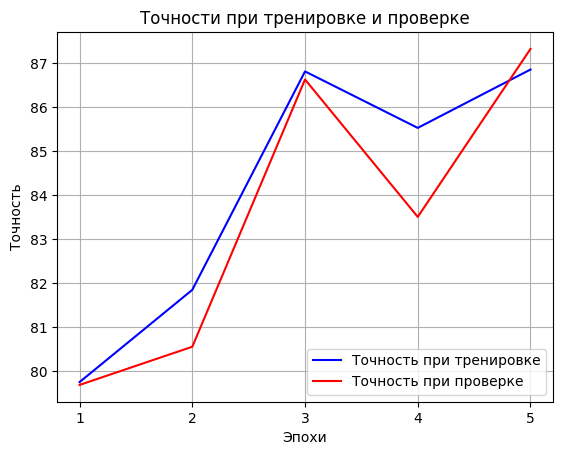

In [19]:
train_model(get_data, get_model, train_batch, accuracy, num_epochs=5)

### Добавление регуляризации

In [20]:
def get_model():
    model = nn.Sequential(
        conv_layer(3, 64, 3),
        nn.Dropout(0.5),
        conv_layer(64, 128, 3),
        nn.Dropout(0.5),
        conv_layer(128, 256, 3),
        nn.Dropout(0.5),
        nn.Flatten(),
        nn.Linear(256 * 26 * 26, 1),
        nn.Sigmoid(),
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Dropout(p=0.5, inplace=False)
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Dropout(p=0.5, inplace=False)
  (4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (5): Dropout(p=0.5, inplace=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_fea

<ipython-input-18-9c826812fe9e>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x*100:.0f}' for x in plt.gca().get_yticks()])


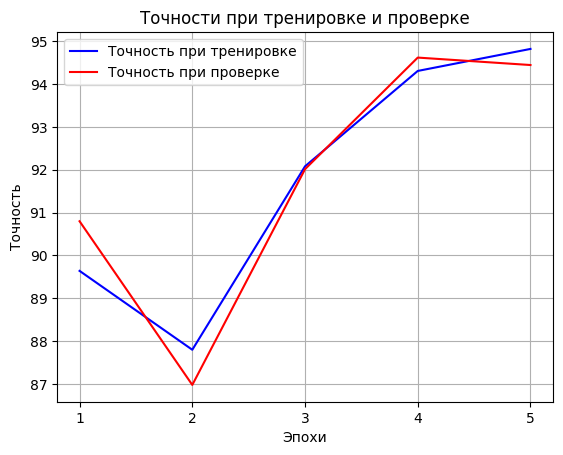

In [21]:
train_model(get_data, get_model, train_batch, accuracy, num_epochs=5)

### Настройка гиперпараметров

In [22]:
def get_model():
    model = nn.Sequential(
        conv_layer(3, 64, 3),
        conv_layer(64, 128, 3),
        conv_layer(128, 256, 3),
        nn.Flatten(),
        nn.Linear(256 * 26 * 26, 1),  # Размер после свёрточных слоёв и максимального пулинга
        nn.Sigmoid(),
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Уменьшение learning rate
    return model, loss_fn, optimizer

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=173056, out_features=1, bias=True)
  (5): Sigmoid()
)


<ipython-input-18-9c826812fe9e>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x*100:.0f}' for x in plt.gca().get_yticks()])


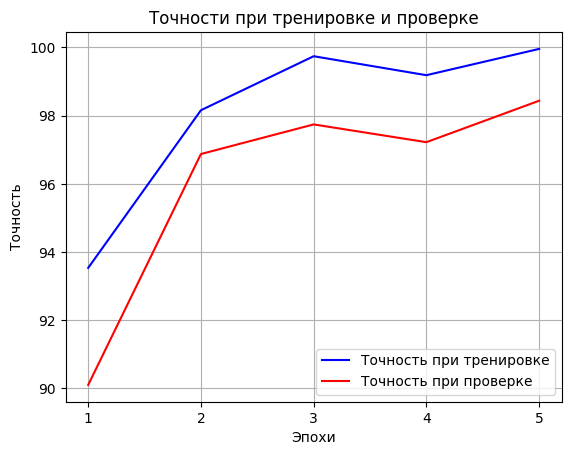

In [23]:
train_model(get_data, get_model, train_batch, accuracy, num_epochs=5)

### Использование CrossEntropyLoss

In [24]:
def get_model():
    model = nn.Sequential(
        conv_layer(3, 64, 3),
        conv_layer(64, 128, 3),
        conv_layer(128, 256, 3),
        nn.Flatten(),
        nn.Linear(256 * 26 * 26, 1),
        nn.Sigmoid(),
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=173056, out_features=1, bias=True)
  (5): Sigmoid()
)


<ipython-input-18-9c826812fe9e>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x*100:.0f}' for x in plt.gca().get_yticks()])


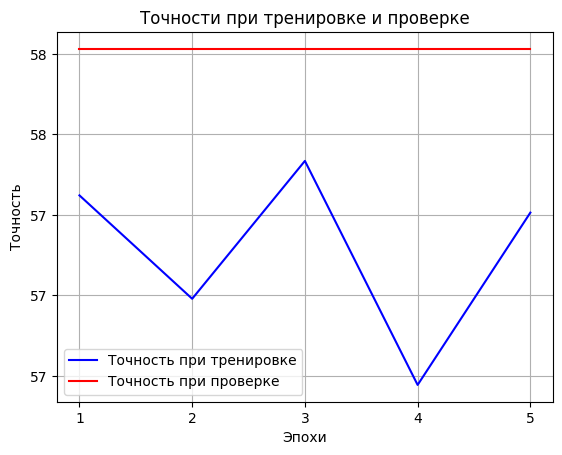

In [25]:
train_model(get_data, get_model, train_batch, accuracy, num_epochs=5)

# Задание 2

Для набора данных изучить влияние точности модели от количества слоев. Построить графики кривых обучения и интерпретировать.

### 2 слоя

In [26]:
def get_model():
    model = nn.Sequential(
        conv_layer(3, 64, 3),
        conv_layer(64, 128, 3),
        nn.Flatten(),
        nn.Linear(128 * 54 * 54, 1),
        nn.Sigmoid(),
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    return model, loss_fn, optimizer

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=373248, out_features=1, bias=True)
  (4): Sigmoid()
)


<ipython-input-18-9c826812fe9e>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x*100:.0f}' for x in plt.gca().get_yticks()])


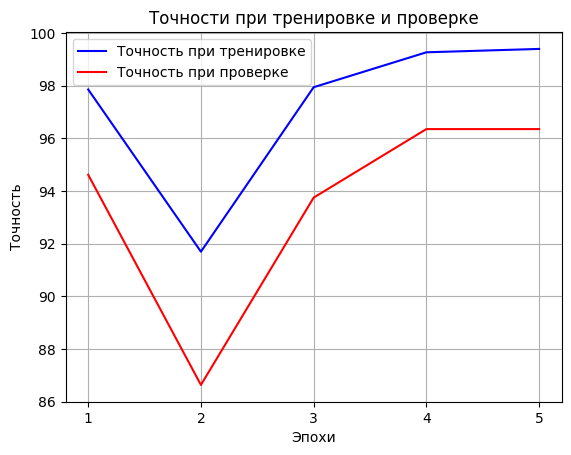

In [27]:
train_model(get_data, get_model, train_batch, accuracy, num_epochs=5)

### 3 слоя

In [28]:
def get_model():
    model = nn.Sequential(
        conv_layer(3, 64, 3),
        conv_layer(64, 128, 3),
        conv_layer(128, 256, 3),
        nn.Flatten(),
        nn.Linear(256 * 26 * 26, 1),
        nn.Sigmoid(),
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=173056, out_features=1, bias=True)
  (5): Sigmoid()
)


<ipython-input-18-9c826812fe9e>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x*100:.0f}' for x in plt.gca().get_yticks()])


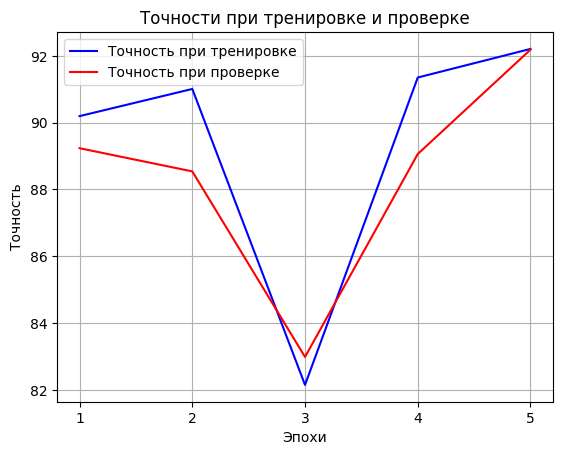

In [29]:
train_model(get_data, get_model, train_batch, accuracy, num_epochs=5)

### 4 слоя

In [30]:
def get_model():
    model = nn.Sequential(
        conv_layer(3, 64, 3),
        conv_layer(64, 128, 3),
        conv_layer(128, 256, 3),
        conv_layer(256, 512, 3),
        nn.Flatten(),
        nn.Linear(512 * 12 * 12, 1),
        nn.Sigmoid(),
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    return model, loss_fn, optimizer

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_runni

<ipython-input-18-9c826812fe9e>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x*100:.0f}' for x in plt.gca().get_yticks()])


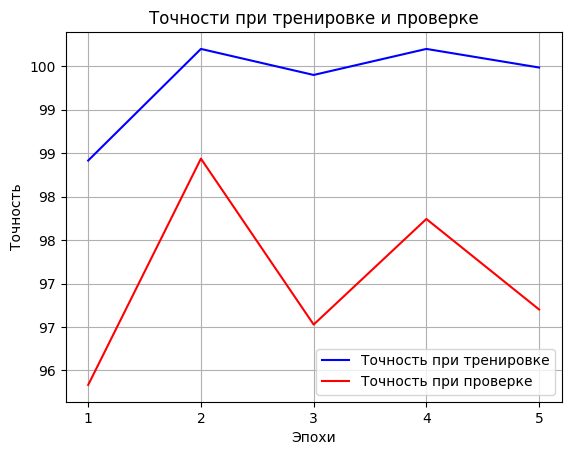

In [31]:
train_model(get_data, get_model, train_batch, accuracy, num_epochs=5)